# ML draft

Method and code is adopted from https://github.com/morrismanfung/yukoproject2022/blob/main/02-model/001-knn.ipynb

## General Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
data_full = pd.read_csv( 'data/risk_factors_cervical_cancer.csv')

In [3]:
data_full.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [4]:
data_full[ 'target'] = data_full[ 'Hinselmann'] | data_full[ 'Schiller'] | data_full[ 'Citology'] | data_full[ 'Biopsy']
data_full = data_full.replace('?', np.nan)

In [5]:
data_full[ 'target'].value_counts()

0    756
1    102
Name: target, dtype: int64

In [6]:
STDs = ['STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV']

for i in STDs:
    print( i)
    print( data_full[ i].value_counts())
    print()

STDs:condylomatosis
0.0    709
1.0     44
Name: STDs:condylomatosis, dtype: int64

STDs:cervical condylomatosis
0.0    753
Name: STDs:cervical condylomatosis, dtype: int64

STDs:vaginal condylomatosis
0.0    749
1.0      4
Name: STDs:vaginal condylomatosis, dtype: int64

STDs:vulvo-perineal condylomatosis
0.0    710
1.0     43
Name: STDs:vulvo-perineal condylomatosis, dtype: int64

STDs:syphilis
0.0    735
1.0     18
Name: STDs:syphilis, dtype: int64

STDs:pelvic inflammatory disease
0.0    752
1.0      1
Name: STDs:pelvic inflammatory disease, dtype: int64

STDs:genital herpes
0.0    752
1.0      1
Name: STDs:genital herpes, dtype: int64

STDs:molluscum contagiosum
0.0    752
1.0      1
Name: STDs:molluscum contagiosum, dtype: int64

STDs:AIDS
0.0    753
Name: STDs:AIDS, dtype: int64

STDs:HIV
0.0    735
1.0     18
Name: STDs:HIV, dtype: int64



In [7]:
Dxs = ['Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']
for i in Dxs:
    print( i)
    print( data_full[ i].value_counts())
    print()

Dx:Cancer
0    840
1     18
Name: Dx:Cancer, dtype: int64

Dx:CIN
0    849
1      9
Name: Dx:CIN, dtype: int64

Dx:HPV
0    840
1     18
Name: Dx:HPV, dtype: int64

Dx
0    834
1     24
Name: Dx, dtype: int64



In [8]:
columns_tbc = [ # to be considered
    'Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)',
    'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV']

In [9]:
data_full[ columns_tbc].columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV'],
      dtype='object')

In [10]:
numeric_features = [ 'Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)']
binary_features = ['Dx:Cancer', 'Dx:CIN', 'Dx:HPV']

column_transformer = make_column_transformer(
    ( make_pipeline( SimpleImputer( strategy = 'median'), PowerTransformer(), StandardScaler()), numeric_features),
    ( SimpleImputer( strategy = 'most_frequent'), binary_features)
)

In [11]:
X = data_full[ columns_tbc]
y = data_full[ 'target']

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.5, stratify = y, random_state = 123)

## KNN

In [13]:
pipe_knn = make_pipeline( column_transformer, KNeighborsClassifier()) # No class weight in KNN
cv_result = cross_validate( pipe_knn, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.184484,0.056951,0.0,0.04878
1,0.123008,0.056483,0.0,0.04878
2,0.121083,0.045700,0.0,0.00000
3,0.105859,0.037334,0.0,0.17500
4,0.186444,0.060564,0.0,0.02439


In [14]:
param_grid = {
    "kneighborsclassifier__n_neighbors": list( range( 5, 35, 5))
}

grid_search = GridSearchCV(
    pipe_knn, param_grid, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True
)

grid_search.fit( X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False)

,params,mean_test_score
0,{'kneighborsclassifier__n_neighbors': 5},0.0
1,{'kneighborsclassifier__n_neighbors': 10},0.0
2,{'kneighborsclassifier__n_neighbors': 15},0.0
3,{'kneighborsclassifier__n_neighbors': 20},0.0
4,{'kneighborsclassifier__n_neighbors': 25},0.0
5,{'kneighborsclassifier__n_neighbors': 30},0.0


In [15]:
y_hat = grid_search.predict( X_test)

In [16]:
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[376   2]
 [ 51   0]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       378
           1       0.00      0.00      0.00        51

    accuracy                           0.88       429
   macro avg       0.44      0.50      0.47       429
weighted avg       0.78      0.88      0.82       429



## SVC

In [17]:
pipe_svc = make_pipeline( column_transformer, SVC( class_weight = 'balanced'))
cv_result = cross_validate( pipe_svc, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.097366,0.032081,0.300000,0.829268
1,0.120451,0.028824,0.400000,0.780488
2,0.135314,0.039361,0.500000,0.780488
3,0.113636,0.020884,0.272727,0.825000
4,0.109339,0.032303,0.400000,0.780488


In [18]:
param_dist = {
    'svc__C': [ 10**x for x in range( -2, 5)],
    'svc__gamma': [ 10**x for x in range( -2, 5)]
}

random_search = RandomizedSearchCV(
    pipe_svc, param_dist, n_iter = 30, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True
)

random_search.fit( X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('powertransformer',
                                                                                                PowerTransformer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Number '
                                                                                'of '
                                                                                'sexual '
                                                                                'partners',
                                                                                'First '
                                                                                'sexual '
                                                                                'intercourse',
                                                                                'Num '
                                                                                'of '
                                                                                'pregnancies',...
                                                                                'Contraceptives '
                                                                                '(years)',
                                                                                'IUD '
                                                                                '(years)',
                                                                                'STDs '
                                                                                '(number)']),
                                                                              ('simpleimputer',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['Dx:Cancer',
                                                                                'Dx:CIN',
                                                                                'Dx:HPV'])])),
                                             ('svc',
                                              SVC(class_weight='balanced'))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'svc__C': [0.01, 0.1, 1, 10, 100, 1000,
                                                   10000],
                                        'svc__gamma': [0.01, 0.1, 1, 10, 100,
                                                       1000, 10000]},
                   return_train_score=True, scoring='recall')

In [19]:
results = pd.DataFrame( random_search.cv_results_)
results[ ['params', 'mean_test_score', 'mean_train_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score,mean_train_score
12,"{'svc__gamma': 0.1, 'svc__C': 0.1}",0.610909,0.701098
24,"{'svc__gamma': 0.01, 'svc__C': 1}",0.432727,0.529512
7,"{'svc__gamma': 0.01, 'svc__C': 10}",0.392727,0.686220
21,"{'svc__gamma': 0.01, 'svc__C': 100}",0.374545,0.804146
9,"{'svc__gamma': 0.01, 'svc__C': 0.1}",0.258182,0.254756


In [20]:
y_hat = random_search.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[245 133]
 [ 29  22]]
              precision    recall  f1-score   support

           0       0.89      0.65      0.75       378
           1       0.14      0.43      0.21        51

    accuracy                           0.62       429
   macro avg       0.52      0.54      0.48       429
weighted avg       0.80      0.62      0.69       429



Try a less complex model to reduce overfitting.

In [21]:
pipe_svc_opt = make_pipeline( column_transformer, SVC( class_weight = 'balanced', gamma = 10, C = 0.1))
pipe_svc_opt.fit( X_train, y_train)
y_hat = pipe_svc_opt.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[  0 378]
 [  0  51]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       378
           1       0.12      1.00      0.21        51

    accuracy                           0.12       429
   macro avg       0.06      0.50      0.11       429
weighted avg       0.01      0.12      0.03       429



C:\Users\User\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
precision, recall, thresholds = precision_recall_curve( y_test, pipe_svc_opt.decision_function( X_test))

In [23]:
def pr_curve( precision, recall):
    plot_df = pd.DataFrame( {
        'precision': precision,
        'recall': recall
    })

    chart = alt.Chart( plot_df).mark_point().encode(
        x = 'precision',
        y = 'recall'
    ).properties( height = 300, width = 300)
    return chart

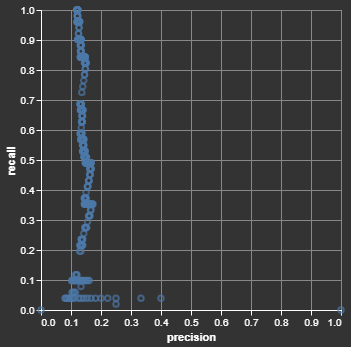

In [24]:
pr_curve( precision, recall)

## Random Forest (Let's give it a try :))

In [25]:
from sklearn.ensemble import RandomForestClassifier
pipe_rfc = make_pipeline( column_transformer, RandomForestClassifier( class_weight = 'balanced', random_state = 123))
cv_result = cross_validate( pipe_rfc, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.982766,0.097469,0.0,1.0
1,0.704974,0.085170,0.1,1.0
2,0.821078,0.086631,0.0,1.0
3,0.770409,0.081645,0.0,1.0
4,0.745378,0.084239,0.1,1.0


In [26]:
param_dist = {
    'randomforestclassifier__n_estimators': [ 100*x for x in range( 1, 11)],
    'randomforestclassifier__max_depth': [ 10*x for x in range( 1, 11)],
    'randomforestclassifier__max_features': [ 'sqrt', 'log2'],
    'randomforestclassifier__criterion': [ 'gini', 'entropy', 'log_loss'],
    'randomforestclassifier__bootstrap': [ True, False]
}

random_search = RandomizedSearchCV(
    pipe_rfc, param_dist, n_iter = 30, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True, random_state = 918
)

random_search.fit( X_train, y_train)

results = pd.DataFrame(random_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
15,"{'randomforestclassifier__n_estimators': 400, ...",0.1
17,"{'randomforestclassifier__n_estimators': 700, ...",0.1
3,"{'randomforestclassifier__n_estimators': 700, ...",0.1
4,"{'randomforestclassifier__n_estimators': 400, ...",0.1
6,"{'randomforestclassifier__n_estimators': 800, ...",0.1


In [27]:
print( results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).iloc[ 0, 0])
y_hat = random_search.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

{'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 90, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False}
[[364  14]
 [ 50   1]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       378
           1       0.07      0.02      0.03        51

    accuracy                           0.85       429
   macro avg       0.47      0.49      0.47       429
weighted avg       0.78      0.85      0.81       429



In [28]:
precision, recall, thresholds = precision_recall_curve( y_test, random_search.predict_proba( X_test)[:,1])

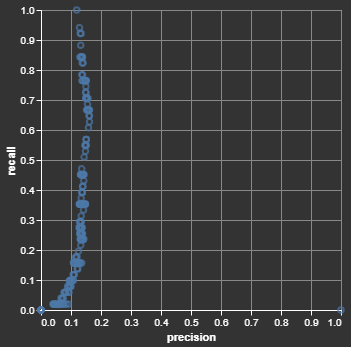

In [29]:
pr_curve( precision, recall)

## Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

pipe_nb = make_pipeline( column_transformer, GaussianNB())
cv_result = cross_validate( pipe_nb, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.107252,0.020460,0.200000,0.170732
1,0.053381,0.013100,0.200000,0.268293
2,0.070686,0.018163,0.100000,0.219512
3,0.072692,0.026022,0.181818,0.250000
4,0.080101,0.012381,0.300000,0.219512


In [31]:
pipe_nb.fit( X_train, y_train) # As no hyperparameter optimization for Gaussian naive Bayes
y_hat = pipe_nb.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[358  20]
 [ 40  11]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       378
           1       0.35      0.22      0.27        51

    accuracy                           0.86       429
   macro avg       0.63      0.58      0.60       429
weighted avg       0.83      0.86      0.84       429



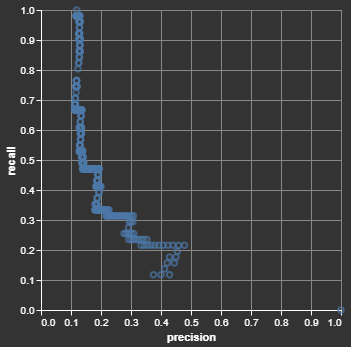

In [32]:
precision, recall, thresholds = precision_recall_curve( y_test, pipe_nb.predict_proba( X_test)[:,1])
pr_curve( precision, recall)

## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
pipe_logreg = make_pipeline( column_transformer, LogisticRegression( max_iter = 1000, solver = 'saga', class_weight = 'balanced', random_state = 123))
cv_result = cross_validate( pipe_logreg, X_train, y_train, cv = 5, return_train_score = True, scoring = 'recall')
pd.DataFrame( cv_result)

,fit_time,score_time,test_score,train_score
0,0.103786,0.012833,0.600000,0.658537
1,0.092027,0.025901,0.700000,0.609756
2,0.076869,0.007253,0.200000,0.658537
3,0.074495,0.009935,0.545455,0.575000
4,0.055669,0.002043,0.500000,0.609756


In [34]:
param_dist = {
    'logisticregression__C': [ 10**x for x in range( -2, 5)],
    'logisticregression__penalty': [ 'none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__l1_ratio': [ 0, 0.5, 1]
}

grid_search = GridSearchCV(
    pipe_logreg, param_dist, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

grid_search.fit( X_train, y_train)

results = pd.DataFrame( grid_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


,params,mean_test_score
26,"{'logisticregression__C': 1, 'logisticregressi...",0.211881
30,"{'logisticregression__C': 1, 'logisticregressi...",0.211881
34,"{'logisticregression__C': 1, 'logisticregressi...",0.211881
35,"{'logisticregression__C': 1, 'logisticregressi...",0.211881
13,"{'logisticregression__C': 0.1, 'logisticregres...",0.198512


In [35]:
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).iloc[ 0, 0]

{'logisticregression__C': 1,
 'logisticregression__l1_ratio': 0,
 'logisticregression__penalty': 'l1'}

In [36]:
y_hat = grid_search.predict( X_test)
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[253 125]
 [ 29  22]]
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       378
           1       0.15      0.43      0.22        51

    accuracy                           0.64       429
   macro avg       0.52      0.55      0.49       429
weighted avg       0.81      0.64      0.70       429



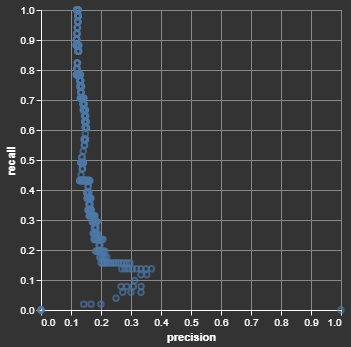

In [37]:
precision, recall, thresholds = precision_recall_curve( y_test, grid_search.predict_proba( X_test)[:,1])
pr_curve( precision, recall)

In [38]:
plot_df = pd.DataFrame( {
    'precision': precision,
    'recall': recall
})

chart = alt.Chart( plot_df).mark_point().encode(
    x = 'precision',
    y = 'recall'
).properties( height = 300, width = 300)

In [39]:
len( precision), len( thresholds)

(420, 419)

In [40]:
thresholds = np.append( thresholds, 1)

In [41]:
plt_df = pd.DataFrame( {
    'precision': precision,
    'recall': recall,
    'thresholds': thresholds
})

chart = alt.Chart( plt_df).mark_point().encode(
    x = 'thresholds',
    y = 'recall',
).properties( height = 300, width = 300)

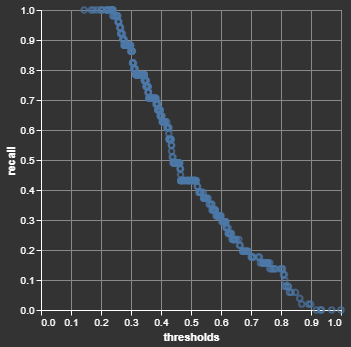

In [42]:
chart

In [43]:
plt_df

,precision,recall,thresholds
0,0.118881,1.0,0.143878
1,0.119159,1.0,0.167694
2,0.119438,1.0,0.174652
3,0.119718,1.0,0.187636
4,0.120000,1.0,0.199120
...,...,...,...
415,0.000000,0.0,0.917826
416,0.000000,0.0,0.933401
417,0.000000,0.0,0.934289
418,0.000000,0.0,0.968807


In [44]:
y_hat = grid_search.predict_proba( X_test)[:,1] > 0.934289
print( confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print( classification_report( y_test, y_hat))

[[376   2]
 [ 51   0]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       378
           1       0.00      0.00      0.00        51

    accuracy                           0.88       429
   macro avg       0.44      0.50      0.47       429
weighted avg       0.78      0.88      0.82       429

